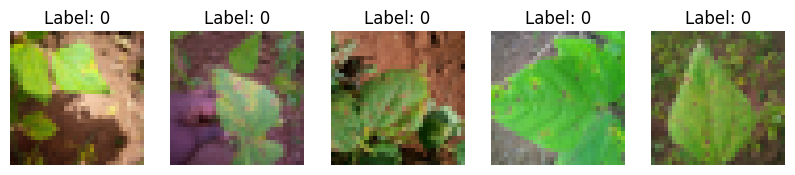

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3956 - loss: 1.0886 - val_accuracy: 0.4737 - val_loss: 0.9801
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5600 - loss: 0.9459 - val_accuracy: 0.6015 - val_loss: 0.8551
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6237 - loss: 0.8644 - val_accuracy: 0.5940 - val_loss: 0.8393
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5872 - loss: 0.8488 - val_accuracy: 0.6917 - val_loss: 0.7462
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6673 - loss: 0.7910 - val_accuracy: 0.6992 - val_loss: 0.7104
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6709 - loss: 0.7578 - val_accuracy: 0.7068 - val_loss: 0.7077
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6818 - loss: 0.7421 - val_accuracy: 0.6692 - val_loss: 0.7192
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7117 - loss: 0.7095 - val_accuracy: 0.6767 - v

ValueError: Input size must be at least 32x32; Received: input_shape=(28, 28, 3)

In [ ]:
# 1️⃣ IMPORTS Y CONFIGURACIÓN
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# CARGA Y PREPROCESAMIENTO
splits = {
    "train":       "data/train-00000-of-00001.parquet",
    "validation":  "data/validation-00000-of-00001.parquet",
    "test":        "data/test-00000-of-00001.parquet",
}

df_train = pd.read_parquet("hf://datasets/AI-Lab-Makerere/beans/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/AI-Lab-Makerere/beans/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/AI-Lab-Makerere/beans/" + splits["test"])

def decode_image(byte_data, target_size=(32, 32)):
    from PIL import Image
    import io
    image = Image.open(io.BytesIO(byte_data)).convert("RGB")
    image = image.resize(target_size)
    return np.array(image) / 255.0


# Procesar dataset
def prepare_dataset(df, target_size=(28, 28)):
    X = np.array([decode_image(b['bytes'], target_size) for b in df['image']])
    y = to_categorical(df['labels'])
    return X, y

X_train, y_train = prepare_dataset(df_train, target_size=(32, 32))
X_val, y_val = prepare_dataset(df_val, target_size=(32, 32))
X_test, y_test = prepare_dataset(df_test, target_size=(32, 32))


# Visualización
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.title(f"Label: {np.argmax(y_train[i])}")
    plt.axis('off')
plt.show()

#BASELINE CNN
model_cnn = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(y_train.shape[1], activation='softmax')
])

model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('baseline_cnn.keras', save_best_only=True)
]

history_cnn = model_cnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=callbacks
)

#TRANSFER LEARNING
def build_transfer_model(base_model):
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(y_train.shape[1], activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# VGG16
vgg_base = VGG16(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
model_vgg = build_transfer_model(vgg_base)
# Convierte a 3 canales para VGG16
X_train_vgg = np.array([decode_image(b['bytes'], target_size=(32, 32)) for b in df_train['image']])
X_val_vgg = np.repeat(X_val, 3, axis=-1)
X_test_vgg = np.repeat(X_test, 3, axis=-1)

history_vgg = model_vgg.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint('vgg_model.keras', save_best_only=True)
    ]
)

In [15]:
# MobileNetV2
mobilenet_base = MobileNetV2(include_top=False, weights='imagenet', input_shape=(32, 32, 3))
model_mobilenet = build_transfer_model(mobilenet_base)

C:\Users\Maria Paula\AppData\Local\Temp\ipykernel_17304\3001162381.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet_base = MobileNetV2(include_top=False, weights='imagenet', input_shape=(32, 32, 3))


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6266 - loss: 0.8332 - val_accuracy: 0.5489 - val_loss: 0.9679
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.6057 - loss: 0.8379 - val_accuracy: 0.5639 - val_loss: 0.9680
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6309 - loss: 0.8338 - val_accuracy: 0.5639 - val_loss: 0.9680
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.6425 - loss: 0.8197 - val_accuracy: 0.5865 - val_loss: 0.9664
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6385 - loss: 0.8140 - val_accuracy: 0.5714 - val_loss: 0.9634
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6359 - loss: 0.8077 - val_accuracy: 0.5639 - val_loss: 0.9691
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6635 - loss: 0.7997 - val_accuracy: 0.5714 - val_loss: 0.9665
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6399 - loss: 0.7890 - val_accuracy: 0.5714 - v

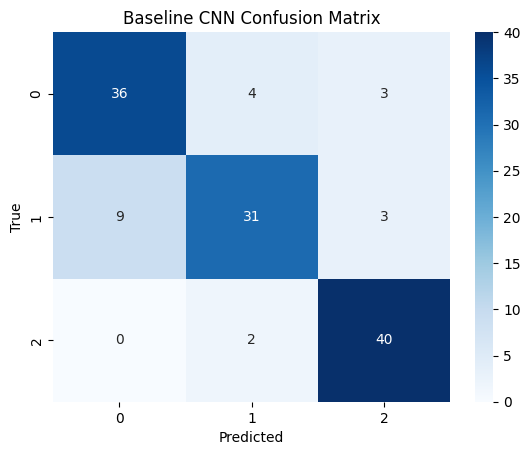

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 109ms/step

VGG16 Transfer Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.67      0.72        43
           1       0.64      0.74      0.69        43
           2       0.83      0.81      0.82        42

    accuracy                           0.74       128
   macro avg       0.75      0.74      0.74       128
weighted avg       0.75      0.74      0.74       128



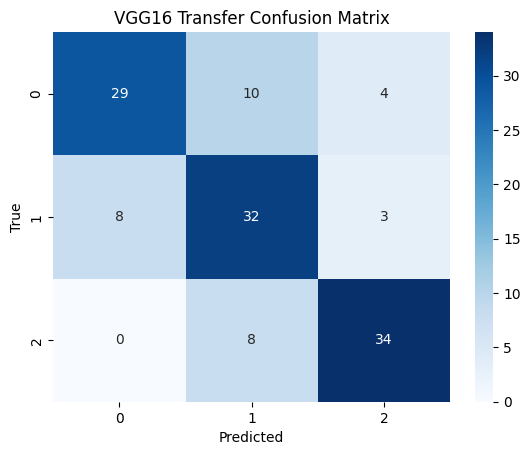

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

MobileNetV2 Transfer Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.60      0.57        43
           1       0.50      0.49      0.49        43
           2       0.68      0.62      0.65        42

    accuracy                           0.57       128
   macro avg       0.58      0.57      0.57       128
weighted avg       0.57      0.57      0.57       128



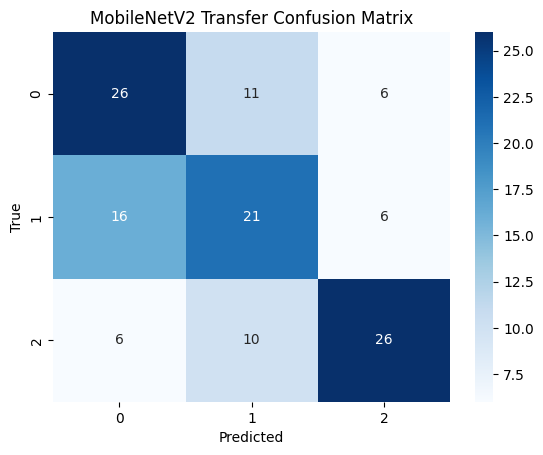

In [ ]:
history_mobilenet = model_mobilenet.fit(
    X_train, y_train,
      validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint('mobilenet_model.keras', save_best_only=True)
    ]
)

#EVALUACIÓN
def evaluate_model(model, X_test, y_test, name):
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

evaluate_model(model_cnn, X_test, y_test, "Baseline CNN")
evaluate_model(model_vgg, X_test, y_test, "VGG16 Transfer")
evaluate_model(model_mobilenet, X_test, y_test, "MobileNetV2 Transfer")
